In [79]:
# load checkpoint
import torch
import dill
import hydra
checkpoint = "data/outputs/2025.08.15/11.12.58_act_coffee_d2/checkpoints/latest.ckpt"
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg']
print(cfg)
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg, output_dir="")
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


{'name': 'act', '_target_': 'equi_diffpo.workspace.train_act_equi_workspace.TrainActEquiWorkspace', 'shape_meta': {'obs': {'agentview_image': {'shape': [3, 84, 84], 'type': 'rgb'}, 'robot0_eye_in_hand_image': {'shape': [3, 84, 84], 'type': 'rgb'}, 'robot0_eef_pos': {'shape': [3]}, 'robot0_eef_quat': {'shape': [4]}, 'robot0_gripper_qpos': {'shape': [2]}}, 'action': {'shape': [10]}}, 'exp_name': 'default', 'task_name': 'coffee_d2', 'n_demo': 100, 'horizon': 10, 'n_obs_steps': 1, 'n_action_steps': 10, 'n_latency_steps': 0, 'dataset_obs_steps': 1, 'past_action_visible': False, 'dataset': 'equi_diffpo.dataset.robomimic_replay_image_dataset.RobomimicReplayImageDataset', 'dataset_path': 'data/robomimic/datasets/coffee_d2/coffee_d2_abs.hdf5', 'policy': {'_target_': 'equi_diffpo.policy.act_equi_policy.ACTPolicyWrapper', 'shape_meta': {'obs': {'agentview_image': {'shape': [3, 84, 84], 'type': 'rgb'}, 'robot0_eye_in_hand_image': {'shape': [3, 84, 84], 'type': 'rgb'}, 'robot0_eef_pos': {'shape': [

/home/rtx8/miniconda3/envs/equidiff/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rtx8/miniconda3/envs/equidiff/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of parameters: 85.04M
transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.norm2.weight
transformer.encoder.layers.0.norm2.bias
transformer.encoder.layers.1.self_attn.in_proj_weight
transformer.encoder.layers.1.self_attn.in_proj_bias
transformer.encoder.layers.1.self_attn.out_proj.weight
transformer.encoder.layers.1.self_attn.out_proj.bias
transformer.encoder.layers.1.linear1.weight
transformer.encoder.layers.1.linear1.bias
transformer.encoder.layers.1.linear2.weight
transformer.encoder.layers.1.linear2.bias
transformer.encoder.layers.1.norm1.

In [80]:
# configure dataset
from torch.utils.data import DataLoader

dataset = hydra.utils.instantiate(cfg.task.dataset)
train_dataloader = DataLoader(dataset, **cfg.dataloader)
normalizer = dataset.get_normalizer()

# configure validation dataset
val_dataset = dataset.get_validation_dataset()
val_dataloader = DataLoader(val_dataset, **cfg.val_dataloader)


Acquiring lock on cache.
Loading cached ReplayBuffer from Disk.
Loaded!


In [81]:
workspace.model.set_normalizer(normalizer)
normalizer = workspace.model.normalizer['action']
model = workspace.model.model


In [82]:
action = dataset[50]['action']

In [83]:
sample = dataset[50]['obs']

In [84]:
sample['robot0_eef_pos']

tensor([[-0.0046, -0.2464,  0.8639]])

In [85]:
import torch
# open h5py
batch_size = 1
qpos = sample

agent_image = torch.tensor(sample['agentview_image'])
in_hand_image = torch.tensor(sample['robot0_eye_in_hand_image'])

images = torch.stack([agent_image, in_hand_image], dim=1)

a_hat = model(qpos, images, None)
a_hat = normalizer.unnormalize(a_hat)

/tmp/ipykernel_36270/736003874.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  agent_image = torch.tensor(sample['agentview_image'])
/tmp/ipykernel_36270/736003874.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_hand_image = torch.tensor(sample['robot0_eye_in_hand_image'])


In [86]:
def quat_mul(q1, q2):
    # q1, q2: (..., 4)
    w1, x1, y1, z1 = q1.unbind(-1)
    w2, x2, y2, z2 = q2.unbind(-1)
    return torch.stack((
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ), dim=-1)

In [87]:
import torch.nn.functional as F
import math
def rotate_qpos(qpos, angle):
    """Rotate the end-effector position and quaternion by a given angle around Z-axis."""
    angle = torch.tensor(angle).float().to(qpos["robot0_eef_pos"].device)
    
    # Z-axis rotation matrix 90 degrees
    rotation_matrix = torch.tensor([
        [torch.cos(angle), -torch.sin(angle), 0],
        [torch.sin(angle), torch.cos(angle), 0],
        [0, 0, 1]
    ]).float().to(qpos["robot0_eef_pos"].device)

    rotated_pos = torch.matmul(qpos["robot0_eef_pos"], rotation_matrix.T)
    
    # Quaternion for Z-axis rotation 90 degrees
    theta = torch.tensor(math.radians(angle)).float().to(qpos["robot0_eef_quat"].device)
    q_rot = torch.tensor([
        torch.cos(theta / 2),  # w
        0,  # x
        0,  # y
        torch.sin(theta / 2)   # z
    ]).float().to(qpos["robot0_eef_quat"].device)
    
    rotated_quat = quat_mul(
        q_rot,
        qpos["robot0_eef_quat"],
    )

    return {
        "robot0_eef_pos": rotated_pos,
        "robot0_eef_quat": rotated_quat,
        "robot0_gripper_qpos": qpos["robot0_gripper_qpos"]
    }
    
def rotate_images(images, angle):
    """Rotate images by a given angle (in radians)."""
    angle = torch.tensor(angle).float().to(images.device)
    
    cos_a = torch.cos(angle)
    sin_a = torch.sin(angle)
    
    # 2D rotation matrix for image rotation
    theta = torch.tensor([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0]
    ]).unsqueeze(0).repeat(images.size(0), 1, 1).float().to(images.device)
    
    grid = F.affine_grid(theta, images.size(), align_corners=False)
    rotated_images = F.grid_sample(images, grid, align_corners=False)
    
    return rotated_images
    
# Rotate by 90 degrees around Z-axis 
rotated_agent_image = rotate_images(agent_image, torch.pi)
rotated_images = torch.stack([rotated_agent_image, in_hand_image], dim=1)
rotated_qpos = rotate_qpos(qpos, torch.pi)
rotated_a_hat = model(rotated_qpos, rotated_images, None)
rotated_a_hat = normalizer.unnormalize(rotated_a_hat)

In [88]:

# Extract data for original action
a_hat_xy = a_hat[0, :, :2].detach().numpy()  # Position (x, y)

# Extract data for rotated action
rotated_a_hat_xy = rotated_a_hat[0, :, :2].detach().numpy()  # Position (x, y)

action_xy = action[:, :2].detach().numpy()  # Original action (x, y)


In [89]:
# rotate ground truth action xy 90 degree on xy plane
import numpy as np
def rotate_action_xy(action_xy, angle):
    """Rotate action coordinates by a given angle around Z-axis."""
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    rotated_action_xy = np.dot(action_xy, rotation_matrix.T)
    return rotated_action_xy
rotated_action_xy = rotate_action_xy(action_xy, torch.pi)  # Rotate by 90 degrees
    

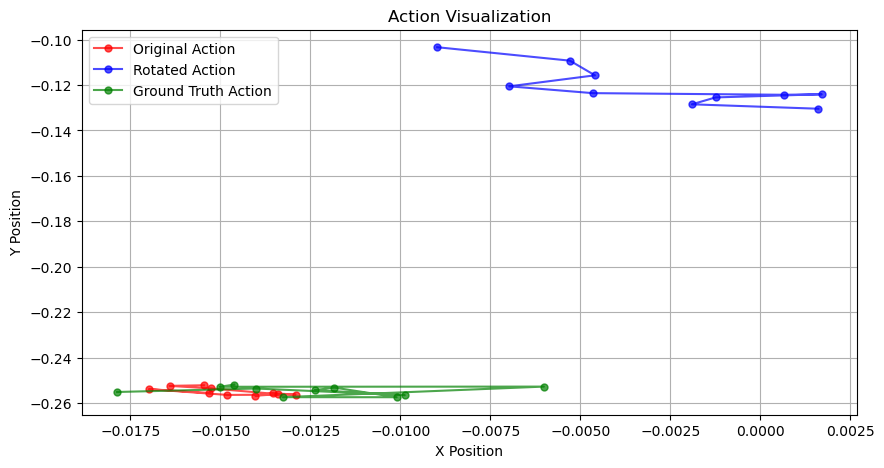

In [96]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure visualizing the original and rotated actions
plt.figure(figsize=(10, 5))
plt.plot(a_hat_xy[:, 0], a_hat_xy[:, 1], 'ro-', label='Original Action', markersize=5, alpha=0.7)
plt.plot(rotated_a_hat_xy[:, 0], rotated_a_hat_xy[:, 1], 'bo-', label='Rotated Action', markersize=5, alpha=0.7)
plt.plot(action_xy[:, 0], action_xy[:, 1], 'go-', label='Ground Truth Action', markersize=5, alpha=0.7)
# plt.plot(rotated_action_xy[:, 0], rotated_action_xy[:, 1], 'mo-', label='Rotated Ground Truth Action', markersize=5, alpha=0.7)
plt.legend()
plt.title('Action Visualization')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid()
plt.show()


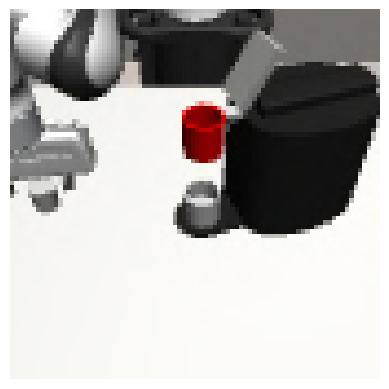

In [91]:
plt.imshow(agent_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

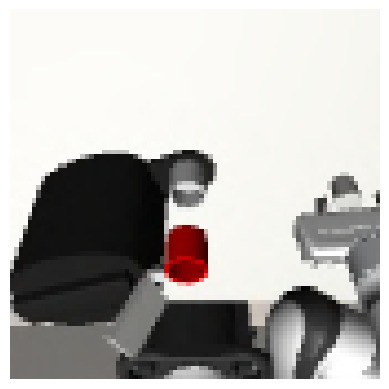

In [92]:
plt.imshow(rotated_agent_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

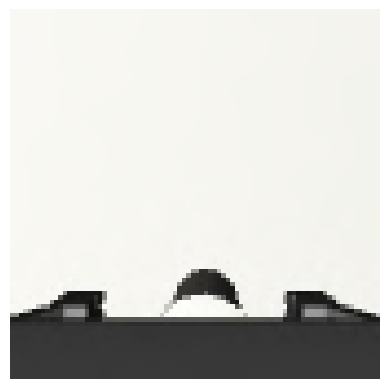

In [93]:
# visualize in hand view image
import matplotlib.pyplot as plt

plt.imshow(in_hand_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


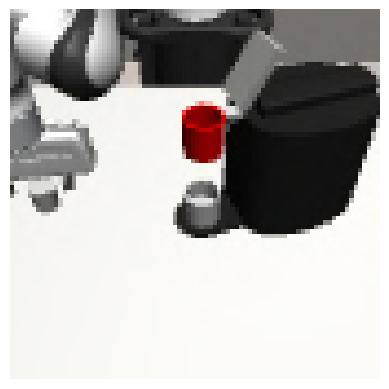

In [94]:
plt.imshow(agent_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [95]:
in_hand_image.shape

torch.Size([1, 3, 84, 84])